In [25]:
%matplotlib inline 
import matplotlib.pyplot as plt
import os
from rdkit import Chem
from rdkit import RDPaths
from functools import partial
from sklearn.metrics import roc_auc_score

import numpy as np
import random
import torch
if torch.cuda.is_available():
    print('use GPU')
    device='cuda'
else:
    print('use CPU')
    device='cpu'
    
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import dgl
from  dgl.data.utils import split_dataset
from dgllife.model import model_zoo

from dgllife.utils import mol_to_complete_graph, mol_to_bigraph
from dgllife.utils import atom_type_one_hot
from dgllife.utils import atom_degree_one_hot
from dgllife.utils import atom_formal_charge
from dgllife.utils import atom_num_radical_electrons
from dgllife.utils import atom_hybridization_one_hot
from dgllife.utils import atom_total_num_H_one_hot
from dgllife.utils import one_hot_encoding
from dgllife.utils import CanonicalAtomFeaturizer
from dgllife.utils import CanonicalBondFeaturizer
from dgllife.utils import ConcatFeaturizer
from dgllife.utils import BaseAtomFeaturizer
from dgllife.utils import BaseBondFeaturizer
from dgllife.utils import one_hot_encoding

use GPU


In [26]:
def chirality(atom):
    try:
        return one_hot_encoding(atom.GetProp('_CIPCode'), ['R', 'S']) + \
               [atom.HasProp('_ChiralityPossible')]
    except:
        return [False, False] + [atom.HasProp('_ChiralityPossible')]
     
def collate_molgraphs(data):
    """Batching a list of datapoints for dataloader.
    Parameters
    ----------
    data : list of 3-tuples or 4-tuples.
        Each tuple is for a single datapoint, consisting of
        a SMILES, a DGLGraph, all-task labels and optionally
        a binary mask indicating the existence of labels.
    Returns
    -------
    smiles : list
        List of smiles
    bg : BatchedDGLGraph
        Batched DGLGraphs
    labels : Tensor of dtype float32 and shape (B, T)
        Batched datapoint labels. B is len(data) and
        T is the number of total tasks.
    masks : Tensor of dtype float32 and shape (B, T)
        Batched datapoint binary mask, indicating the
        existence of labels. If binary masks are not
        provided, return a tensor with ones.
    """
    assert len(data[0]) in [3, 4], \
        'Expect the tuple to be of length 3 or 4, got {:d}'.format(len(data[0]))
    if len(data[0]) == 3:
        smiles, graphs, labels = map(list, zip(*data))
        masks = None
    else:
        smiles, graphs, labels, masks = map(list, zip(*data))
 
    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.stack(labels, dim=0)
     
    if masks is None:
        masks = torch.ones(labels.shape)
    else:
        masks = torch.stack(masks, dim=0)
    return smiles, bg, labels, masks
 
 
def run_a_train_epoch(n_epochs, epoch, model, data_loader,loss_criterion, optimizer):
    model.train()
    total_loss = 0
    losses = []
     
    for batch_id, batch_data in enumerate(data_loader):
        batch_data
        smiles, bg, labels, masks = batch_data
        if torch.cuda.is_available():
            bg.to(torch.device('cuda:0'))
            labels = labels.to('cuda:0')
            masks = masks.to('cuda:0')
         
        prediction = model(bg, bg.ndata['hv'], bg.edata['he'])
        loss = (loss_criterion(prediction, labels)*(masks != 0).float()).mean()
        #loss = loss_criterion(prediction, labels)
        #print(loss.shape)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
         
        losses.append(loss.data.item())
         
 
    total_score = np.mean(losses)
    print('epoch {:d}/{:d}, training {:.4f}'.format( epoch + 1, n_epochs,  total_score))
    return total_score

In [27]:
atom_featurizer = BaseAtomFeaturizer(
                 {'hv': ConcatFeaturizer([
                  partial(atom_type_one_hot, allowable_set=[
                          'B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br', 'Te', 'I', 'At'],
                    encode_unknown=True),
                  partial(atom_degree_one_hot, allowable_set=list(range(6))),
                  atom_formal_charge, atom_num_radical_electrons,
                  partial(atom_hybridization_one_hot, encode_unknown=True),
                  lambda atom: [0], # A placeholder for aromatic information,
                    atom_total_num_H_one_hot, chirality
                 ],
                )})
bond_featurizer = BaseBondFeaturizer({
                                     'he': lambda bond: [0 for _ in range(10)]
    })

In [39]:
train='RDKitBook/data/solubility.train.sdf'
test='RDKitBook/data/solubility.test.sdf'
 
train_mols = Chem.SDMolSupplier(train)
train_smi =[Chem.MolToSmiles(m) for m in train_mols]
train_sol = torch.tensor([float(mol.GetProp('SOL')) for mol in train_mols]).reshape(-1,1)
 
test_mols =  Chem.SDMolSupplier(test)
test_smi = [Chem.MolToSmiles(m) for m in test_mols]
test_sol = torch.tensor([float(mol.GetProp('SOL')) for mol in test_mols]).reshape(-1,1)
 
 
train_graph =[mol_to_bigraph(mol,
                           node_featurizer=atom_featurizer, 
                           edge_featurizer=bond_featurizer) for mol in train_mols]
 
test_graph =[mol_to_bigraph(mol,
                           node_featurizer=atom_featurizer, 
                           edge_featurizer=bond_featurizer) for mol in test_mols]

train_loader = DataLoader(dataset=list(zip(train_smi, train_graph, train_sol)), batch_size=128, collate_fn=collate_molgraphs)
test_loader = DataLoader(dataset=list(zip(test_smi, test_graph, test_sol)), batch_size=128, collate_fn=collate_molgraphs)

In [40]:
model = model_zoo.attentivefp_predictor.AttentiveFPPredictor(node_feat_size=39,
                                  edge_feat_size=10,
                                  num_layers=2,
                                  num_timesteps=2,
                                  graph_feat_size=200,
                                  dropout=0.2)
model = model.to('cuda:0')

In [43]:
loss_fn = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=10 ** (-2.5), weight_decay=10 ** (-5.0),)
n_epochs = 100
epochs = []
scores = []

# Ensure graph and target are on the same device
def run_a_train_epoch(n_epochs, epoch, model, data_loader, loss_criterion, optimizer):
    model.train()
    total_loss = 0
    losses = []
     
    for batch_id, batch_data in enumerate(data_loader):
        smiles, bg, labels, masks = batch_data
        
        # Move batch graph (bg) and labels/masks to the GPU if available
        if torch.cuda.is_available():
            bg = bg.to(torch.device('cuda:0'))
            labels = labels.to(torch.device('cuda:0'))
            masks = masks.to(torch.device('cuda:0'))

        # Extract node and edge features, ensuring they are on the correct device
        node_feats = bg.ndata['hv'].to(torch.device('cuda:0'))
        edge_feats = bg.edata['he'].to(torch.device('cuda:0'))
        
        # Forward pass
        prediction = model(bg, node_feats, edge_feats)
        
        # Compute loss
        loss = (loss_criterion(prediction, labels) * (masks != 0).float()).mean()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
         
        # Track loss
        losses.append(loss.item())
         
    total_score = np.mean(losses)
    print(f'Epoch {epoch + 1}/{n_epochs}, Training Loss: {total_score:.4f}')
    return total_score
    

# Training Loop
for e in range(n_epochs):
    score = run_a_train_epoch(n_epochs, e, model, train_loader, loss_fn, optimizer)
    epochs.append(e)
    scores.append(score)
model.eval()

Epoch 1/100, Training Loss: 9.9542
Epoch 2/100, Training Loss: 4.8677
Epoch 3/100, Training Loss: 3.1593
Epoch 4/100, Training Loss: 2.9854
Epoch 5/100, Training Loss: 2.8084
Epoch 6/100, Training Loss: 2.8264
Epoch 7/100, Training Loss: 1.8833
Epoch 8/100, Training Loss: 1.8384
Epoch 9/100, Training Loss: 2.0473
Epoch 10/100, Training Loss: 1.3347
Epoch 11/100, Training Loss: 1.1422
Epoch 12/100, Training Loss: 0.8328
Epoch 13/100, Training Loss: 0.7167
Epoch 14/100, Training Loss: 0.7239
Epoch 15/100, Training Loss: 0.7596
Epoch 16/100, Training Loss: 0.7984
Epoch 17/100, Training Loss: 0.9546
Epoch 18/100, Training Loss: 0.9995
Epoch 19/100, Training Loss: 0.8772
Epoch 20/100, Training Loss: 0.7417
Epoch 21/100, Training Loss: 0.7957
Epoch 22/100, Training Loss: 0.5825
Epoch 23/100, Training Loss: 0.5239
Epoch 24/100, Training Loss: 0.5375
Epoch 25/100, Training Loss: 0.5113
Epoch 26/100, Training Loss: 0.5075
Epoch 27/100, Training Loss: 0.4982
Epoch 28/100, Training Loss: 0.4251
E

AttentiveFPPredictor(
  (gnn): AttentiveFPGNN(
    (init_context): GetContext(
      (project_node): Sequential(
        (0): Linear(in_features=39, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (project_edge1): Sequential(
        (0): Linear(in_features=49, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (project_edge2): Sequential(
        (0): Dropout(p=0.2, inplace=False)
        (1): Linear(in_features=400, out_features=1, bias=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (attentive_gru): AttentiveGRU1(
        (edge_transform): Sequential(
          (0): Dropout(p=0.2, inplace=False)
          (1): Linear(in_features=200, out_features=200, bias=True)
        )
        (gru): GRUCell(200, 200)
      )
    )
    (gnn_layers): ModuleList(
      (0): GNNLayer(
        (project_edge): Sequential(
          (0): Dropout(p=0.2, inplace=False)
          (1): Linear(in_features=400, out_fea

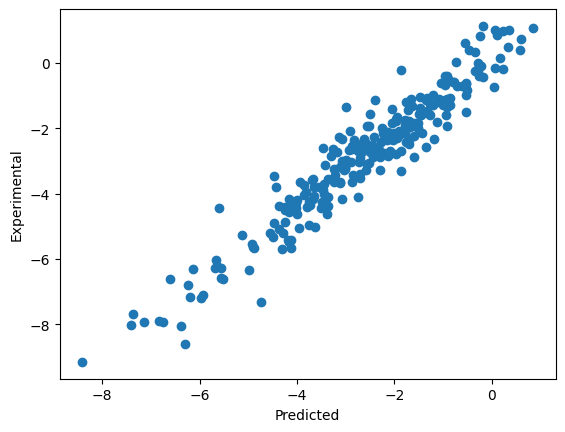

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Plot the training loss (or scores)
plt.plot(epochs, scores)

# Set the model to evaluation mode
model.eval()

# Initialize a list to store all predictions
all_pred = []

# Loop through the test data
for test_data in test_loader:
    smi_lst, bg, labels, masks = test_data
    
    # Move everything to GPU if available
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    bg = bg.to(device)
    labels = labels.to(device)
    masks = masks.to(device)
    
    # Get node and edge features and move them to the correct device
    node_feats = bg.ndata['hv'].to(device)
    edge_feats = bg.edata['he'].to(device)
    
    # Perform the prediction
    pred = model(bg, node_feats, edge_feats)
    
    # Store the predictions on the CPU
    all_pred.append(pred.data.cpu().numpy())

# Convert the predictions to a numpy array
res = np.vstack(all_pred)

# Plot the results
plt.clf()
plt.scatter(res, test_sol)
plt.xlabel('Predicted')
plt.ylabel('Experimental')
plt.show()

0.8944739103317261


/media/suhaib/intensobp/5-Python_envs/pythonvenv/dgl_venv/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


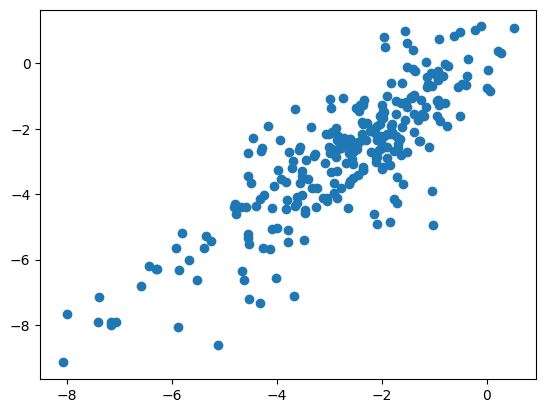

In [48]:
from sklearn.metrics import r2_score
print(r2_score(test_sol, res))

from sklearn.ensemble import RandomForestRegressor
from rdkit import Chem
from rdkit.Chem import AllChem
train_fp = [AllChem.GetMorganFingerprintAsBitVect(mol,2) for mol in train_mols]
test_fp = [AllChem.GetMorganFingerprintAsBitVect(mol,2) for mol in test_mols]
# make RF regressor and train it.
rfr = RandomForestRegressor()
rfr.fit(train_fp, train_sol)

rfr_pred = rfr.predict(test_fp)
r2_score(test_sol, rfr_pred)
plt.clf()
plt.scatter(rfr_pred, test_sol)